# Data Processing

In [ ]:
# Import necessary libraries
import pandas as pd
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
import re
import pickle
from tqdm import tqdm
import matplotlib.pyplot as plt

# Set up tqdm for progress bars
tqdm.pandas()

## Remove Rows and Sample Randomly

We will now drop any rows that are irrelevant to us and save it to a CSV file.

In [ ]:
# Load the dataset
df = pd.read_csv('data/Books_rating.csv')

# Keep only relevant columns and rename for ease of access
df = df[['review/summary', 'review/text', 'review/score']]
df.columns = ['summary', 'text', 'score']

# Sample a portion of the data
n = 250000
df = df.sample(n=n, random_state=1)

# Save to a new CSV file and view data
df.to_csv('data/Books_rating_relevant_columns.csv', index=False)
df.head()

## Stopwords, Lemmatization, and Vectorization

Process the text to remove stopwords, lemmatize, strip unneeded characters, then vectorize.

In [ ]:
# Text processing: Remove stopwords, lemmatize, strip unneeded characters, then vectorize
lemmatizer = WordNetLemmatizer()
stopwords = set(stopwords.words('english'))

def stemmer(text):
    if text != text:
        return ''

    # Clean the text
    text = re.sub(r'[^a-zA-Z0-9]', ' ', text)
    text = re.sub(' +', ' ', text)
    text = text.lower()

    # Tokenize and remove stopwords
    tokens = word_tokenize(text)
    tokens = [w for w in tokens if not w in stopwords]
    tokens = [lemmatizer.lemmatize(w) for w in tokens]
    text = ' '.join(tokens)

    return text

In [ ]:
# Apply stemmer to text
df['stemmed_text'] = df['text'].progress_apply(stemmer)
df['stemmed_summary'] = df['summary'].progress_apply(stemmer)
df['stemmed_summary_text'] = df['stemmed_summary'] + ' ' + df['stemmed_text']

# Remove trailing spaces
df['stemmed_summary_text'] = df['stemmed_summary_text'].progress_apply(
    lambda x: x.strip())

# Clean up NaN and remove empty rows
df.fillna('', inplace=True)
df = df[df['stemmed_summary_text'] != '']

# Drop unused columns
df.drop(columns=['text', 'summary', 'stemmed_summary',
        'stemmed_text'], inplace=True)

# Save to a new CSV file and view the data
df.to_csv('data/Books_rating_stemmed.csv', index=False)
df.head()

## Vectorizing

Vectorize the text using TF-IDF.

In [ ]:
# Vectorize the text using TF-IDF
df = pd.read_csv('data/Books_rating_stemmed.csv')

# Create train and test sets
X_train, X_test, y_train, y_test = train_test_split(df['stemmed_summary_text'], df['score'], test_size=0.2, random_state=1)

# Initialize the vectorizer and fit on the training set
vectorizer = TfidfVectorizer(max_features=30_000, sublinear_tf=True)
vectorizer.fit(X_train)

# Transform training and test sets
X_train = vectorizer.transform(X_train)
X_test = vectorizer.transform(X_test)

# Get the shape of training and test sets
print(f'Shape of training set: {X_train.shape}')
print(f'Shape of testing set: {X_test.shape}')

# Save vectorizer to disk
pickle.dump(vectorizer, open('models/vectorizer.pkl', 'wb'))
print('Vectorizer saved!')

## Model Testing

First testing different kinds of models, then further testing with hyperparameters.

In [ ]:
# Create a dictionary to store model instances
models = {
    'MultinomialNB': MultinomialNB(),
    'LogisticRegression': LogisticRegression(),
    'LinearSVC': LinearSVC()
}

# Create lists to store model names and accuracies for plotting
model_names = []
accuracies = []

# Iterate through models
for name, model in models.items():
    # Fit the model
    model.fit(X_train, y_train)
    
    # Predict on the test set
    y_pred = model.predict(X_test)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    
    # Print classification report for more detailed metrics
    print(f"Classification Report for {name}:")
    print(classification_report(y_test, y_pred))
    
    # Store model name and accuracy for plotting
    model_names.append(name)
    accuracies.append(accuracy)

# Plotting accuracies
plt.bar(model_names, accuracies)
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Model Accuracies')
plt.show()

At this point we decided to further test the LogisticRegression and LinearSVC since the Naive Bayes did not produce favorable results.

### Logistic Regression

We are going to test the logistic regression model with different hyperparameters.

In [ ]:
# Test Logistic Regression with various hyperparameters
penalty = 'l2'
C = [0.01, 0.1, 1]
max_iter = [500, 1000]
solver = ['liblinear', 'saga']
n_jobs = -1
random_state = 42

# Create lists to store hyperparameters and accuracies for plotting
params = []
accuracies = []

# Iterate through hyperparameters
for c in C:
    for i in max_iter:
        for s in solver:
            # Create model instance
            model = LogisticRegression(penalty=penalty, max_iter=i, solver=s, n_jobs=n_jobs, random_state=random_state)
            
            # Test model and store results
            accuracy = model.fit(X_train, y_train).score(X_test, y_test)
            params.append(f'C={c}, max_iter={i}, solver={s}')
            accuracies.append(accuracy)
                
# Plotting accuracies
plt.bar(params, accuracies)
plt.xlabel('Hyperparameters')
plt.ylabel('Accuracy')
plt.title('Logistic Regression Hyperparameters')
plt.xticks(rotation=90)
plt.show()

# Print accuracies
for i in range(len(params)):
    print(f'{params[i]}: {accuracies[i]}')

L1 and L2 regularization refer to Lasso and Ridge regression respectively. Lasso regression penalizes the absolute size of coefficients which results in some coefficients being set to zero. Ridge regression penalizes the squared size of coefficients which results in smaller coefficients but never zero.

Ridge tends to perform better for many significant predictors, while Lasso is more effective when only a few predictors are actually significant​​​. So, we decided to only test with Lasso.

### LinearSVC

We are going to test the LinearSVC model with different hyperparameters.

In [ ]:
# Test Linear SVC with various hyperparameters
penalty = 'l2'
C = [0.01, 0.1, 1]
max_iter = [500, 1000]
loss = ['hinge', 'squared_hinge']
random_state = 42

# Create lists to store hyperparameters and accuracies for plotting
params = []
accuracies = []

# Iterate through hyperparameters
for c in C:
    for i in max_iter:
        for l in loss:
            # Create model instance
            model = LinearSVC(C=c, penalty=penalty, max_iter=i, loss=l, random_state=random_state)
            
            # Test model and store results
            accuracy = model.fit(X_train, y_train).score(X_test, y_test)
            params.append(f'C={c}, max_iter={i}, loss={l}')
            accuracies.append(accuracy)
                
# Plotting accuracies
plt.bar(params, accuracies)
plt.xlabel('Hyperparameters')
plt.ylabel('Accuracy')
plt.title('Linear SVC Hyperparameters')
plt.xticks(rotation=90)
plt.show()

# Print accuracies
for i in range(len(params)):
    print(f'{params[i]}: {accuracies[i]}')

We started to notice that certain hyperparameters do not affect the accuracy at all in the context of this problem. You'll notice repitition in the output. However, logistic regression does edge out LinearSVC by just a little bit so we decided to stick with the configuration that produced those results. Honestly, being just the saga solver.

Chosen Model: `LogisticRegression(random_state=42, max_iter=1000, n_jobs=-1, solver='saga')`

## Supplementing Our Model

So, as a next step (before we attempt a nueral network) we decided to use sentiment analysis via VADER scores. We will then add these scores as features to our model and see if it improves the accuracy.

In [ ]:
# Import necessary libraries for sentiment analysis
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from scipy import sparse as sp

# Download the VADER lexicon
import nltk
nltk.download('vader_lexicon')

# Initialize the VADER Sentiment Intensity Analyzer
sid = SentimentIntensityAnalyzer()

# Apply VADER sentiment analysis to the original 'text' column
df['vader_scores'] = df['stemmed_summary_text'].progress_apply(lambda x: sid.polarity_scores(x)['compound'])

# Save the DataFrame with VADER scores to a new CSV file
df.to_csv('data/Books_rating_vader_scores.csv', index=False)

# View the updated DataFrame
df.head()

Let's perform additional testing using the new feature `vader_scores` and observe any changes in model performance.

In [32]:
# Vectorize the text and VADER scores using TF-IDF
X_text = vectorizer.transform(df['stemmed_summary_text'])
X_vader = df['vader_scores'].values.reshape(-1, 1)

# Concatenate the TF-IDF and VADER score features
X_combined = sp.hstack([X_text, X_vader], format='csr')

# Create train and test sets
X_train_combined, X_test_combined, y_train, y_test = train_test_split(X_combined, df['score'], test_size=0.2, random_state=1)

# Initialize the logistic regression model
model_combined = LogisticRegression(random_state=42, max_iter=1000, n_jobs=-1, solver='saga')

# Fit the model on the combined features
model_combined.fit(X_train_combined, y_train)

# Predict on the test set
y_pred_combined = model_combined.predict(X_test_combined)

# Calculate accuracy and print classification report
accuracy_combined = accuracy_score(y_test, y_pred_combined)
print(f"Combined Model Accuracy: {accuracy_combined}")
print("Classification Report for Combined Model:")
print(classification_report(y_test, y_pred_combined))


Combined Model Accuracy: 0.6812
Classification Report for Combined Model:
              precision    recall  f1-score   support

         1.0       0.63      0.55      0.59      3374
         2.0       0.40      0.20      0.27      2559
         3.0       0.44      0.27      0.34      4218
         4.0       0.45      0.27      0.34      9769
         5.0       0.75      0.93      0.83     30080

    accuracy                           0.68     50000
   macro avg       0.53      0.44      0.47     50000
weighted avg       0.64      0.68      0.65     50000



In [34]:
# only use VADER score to predict
# Create train and test sets
X_train_vader, X_test_vader, y_train, y_test = train_test_split(X_vader, df['score'], test_size=0.2, random_state=1)

# Initialize the logistic regression model
model_vader = LogisticRegression(random_state=42, max_iter=1000, n_jobs=-1, solver='saga')

# Fit the model on the combined features
model_vader.fit(X_train_vader, y_train)

# Predict on the test set
y_pred_vader = model_vader.predict(X_test_vader)

# Calculate accuracy and print classification report
accuracy_vader = accuracy_score(y_test, y_pred_vader)

print(f"VADER Model Accuracy: {accuracy_vader}")

print("Classification Report for VADER Model:")
print(classification_report(y_test, y_pred_vader))

VADER Model Accuracy: 0.59502
Classification Report for VADER Model:
              precision    recall  f1-score   support

         1.0       0.18      0.07      0.11      3374
         2.0       0.00      0.00      0.00      2559
         3.0       0.00      0.00      0.00      4218
         4.0       0.00      0.00      0.00      9769
         5.0       0.61      0.98      0.75     30080

    accuracy                           0.60     50000
   macro avg       0.16      0.21      0.17     50000
weighted avg       0.38      0.60      0.46     50000



/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Now, let's observe and compare the results of using only the text, using VADER scores only, and combining both.

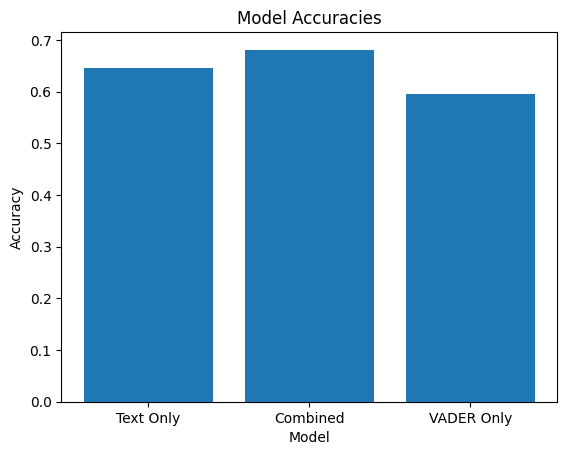

In [35]:
# plot a comparison of the accuracies
plt.bar(['Text Only', 'Combined', 'VADER Only'], [accuracy, accuracy_combined, accuracy_vader])
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Model Accuracies')
plt.show()

VADER scores did not improve the accuracy of our model. In fact, it made it worse. So, we will not be using VADER scores as a feature in our model.

In [ ]:
from textblob import TextBlob

def textblob_sentiment(text):
    analysis = TextBlob(text)
    return analysis.sentiment.polarity

df['textblob_scores'] = df['stemmed_summary_text'].progress_apply(textblob_sentiment)

df['review_length'] = df['stemmed_summary_text'].apply(len)
df['exclamation_count'] = df['stemmed_summary_text'].apply(lambda x: x.count('!'))

from scipy import sparse as sp

# TextBlob sentiment analysis
df['textblob_scores'] = df['stemmed_summary_text'].apply(textblob_sentiment)

# Additional features
df['review_length'] = df['stemmed_summary_text'].apply(len)
df['exclamation_count'] = df['stemmed_summary_text'].apply(lambda x: x.count('!'))

# Combine TF-IDF, VADER, and additional features
X_textblob = df['textblob_scores'].values.reshape(-1, 1)
X_length = df['review_length'].values.reshape(-1, 1)
X_exclamation = df['exclamation_count'].values.reshape(-1, 1)

X_combined = sp.hstack([X_text, X_textblob, X_length, X_exclamation], format='csr')

# Create train and test sets
X_train_combined, X_test_combined, y_train, y_test = train_test_split(X_combined, df['score'], test_size=0.2, random_state=1)

# Initialize the logistic regression model
model_combined = LogisticRegression(random_state=42, max_iter=1000, n_jobs=-1, solver='saga')

# Fit the model on the combined features
model_combined.fit(X_train_combined, y_train)

# Predict on the test set
y_pred_combined = model_combined.predict(X_test_combined)

# Calculate accuracy and print classification report
accuracy_combined = accuracy_score(y_test, y_pred_combined)
print(f"Combined Model Accuracy: {accuracy_combined}")
print("Classification Report for Combined Model:")
print(classification_report(y_test, y_pred_combined))

In [ ]:
# Import necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Flatten
from tensorflow.keras.callbacks import EarlyStopping

# Load the preprocessed data
df = pd.read_csv('data/Books_rating_vader_scores.csv')

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df['stemmed_summary_text'], df['score'], test_size=0.2, random_state=1)

# Vectorize the text using TF-IDF
vectorizer = TfidfVectorizer(max_features=30_000, sublinear_tf=True)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Build a simple neural network
model = Sequential()
model.add(Embedding(input_dim=30_000, output_dim=128, input_length=X_train_tfidf.shape[1]))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(5, activation='linear'))  # Use 'linear' activation for regression tasks

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse'])

# Set up early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Convert sparse matrices to dense arrays for compatibility with Keras
X_train_dense = X_train_tfidf.toarray()
X_test_dense = X_test_tfidf.toarray()

# Train the model
model.fit(X_train_dense, y_train, epochs=10, batch_size=32, validation_data=(X_test_dense, y_test), callbacks=[early_stopping])

# Save the model
model.save('models/nn_model.h5')

# Evaluate the model on the test set
y_pred_nn = model.predict(X_test_tfidf).flatten().round().astype(int)

# Calculate accuracy and print classification report
accuracy_nn = accuracy_score(y_test, y_pred_nn)
print(f"Neural Network Accuracy: {accuracy_nn}")
print("Classification Report for Neural Network:")
print(classification_report(y_test, y_pred_nn))